In [2]:
import sys

sys.path.insert(0, "/mnt/ivy/thliao/project/ML_oxygen/scripts/")
import shap
import xgboost as xgb
from general_func import *
from load_data import *

shap.initjs()
%pylab inline
from IPython.display import Image

8945
8943
(9328, 10054)
Counter({'aerobic': 3767, 'anaerobic': 1714, 'obligate aerobic': 1627, 'facultative': 953, 'microaerophilic': 726, 'obligate anaerobic': 156})


Populating the interactive namespace from numpy and matplotlib


In [3]:

def each_eval(reduced_data, y_bin, n_splits=5,model_f=GBDT_m,return_shap=False,return_models=False):
    best_feas = {}
    shap_dfs = []
    auc_l = []
    acc_l = []
    ap_l = []
    models = []
    c = 0
    sssp = StratifiedShuffleSplit(n_splits=n_splits)
    for train_index, test_index in sssp.split(reduced_data, y_bin):
        X_train_large, X_test_large = (
            reduced_data.iloc[train_index, :],
            reduced_data.iloc[test_index, :],
        )
        y_train_large, y_test_large = y_bin[train_index], y_bin[test_index]
        pred_l, preds, model, accuracy, auc, AP = model_f(
            X_train_large, y_train_large, X_test_large, y_test_large
        )

        if type(model)==xgb.Booster:
            test_d = xgb.DMatrix(X_test_large, label=y_test_large)
            shap_vals = model.predict(test_d, pred_contribs=True)
            shap_vals = shap_vals[:, :-1]  # the last column is the bias term, needed to be removed
            if return_shap:
                shap_df = pd.DataFrame(shap_vals,index=X_test_large.index,columns=X_test_large.columns)
                shap_dfs.append(shap_df)
                continue
            _ko2shap_sum = dict(
                zip(X_test_large.columns, np.sum(np.abs(shap_vals), axis=0))
            )
            best_feas[c] = _ko2shap_sum
        else:
            best_feas[c] = dict(zip(X_test_large.columns,model.coef_[0]))
        auc_l.append(auc)
        acc_l.append(accuracy)
        ap_l.append(AP)
        c += 1
    if return_shap:
        return shap_dfs
    _df = pd.DataFrame.from_dict(best_feas, orient="columns")
    _df = _df.T
    _df.loc[:, "auc"] = auc_l
    _df.loc[:, "acc"] = acc_l
    _df.loc[:, "AP"] = ap_l
    return _df

In [4]:
reduced_pfam = pd.read_csv(
    "/mnt/ivy/thliao/project/ML_oxygen/training_sets/processed_data/CBdist_based_filter/PFAM_reduced.tsv",
    sep="\t",
    index_col=0,
)

In [ ]:
reduced_pfam

In [5]:
reduced_data = pd.read_csv(
    "/mnt/ivy/thliao/project/ML_oxygen/training_sets/processed_data/CBdist_based_filter/keggbin_reduced.tsv",
    sep="\t",
    index_col=0,
)

odir = "/mnt/ivy/thliao/project/ML_oxygen/training_sets/processed_data/CBdist_based_filter/baseline"
# baseline_auc_l = []
# baseline_acc_l = []
# for _ in tqdm(range(50)):
#     _df = pd.read_csv(f"{odir}/{_}.list", sep="\t", index_col=0)
#     _df = _df.T
#     baseline_auc_l += list(_df.loc["auc", :])
#     baseline_acc_l += list(_df.loc["acc", :])
# _df = pd.DataFrame(index=list(range(len(baseline_auc_l))),
#              columns = ['auc','acc'])
# _df.loc[:,'auc'] = baseline_auc_l
# _df.loc[:,'acc'] = baseline_acc_l
# # _df.to_csv("/mnt/ivy/thliao/project/ML_oxygen/training_sets/processed_data/CBdist_based_filter/baseline/summary.tab",sep='\t',index=0)
# _df = pd.read_csv("/mnt/ivy/thliao/project/ML_oxygen/training_sets/processed_data/CBdist_based_filter/baseline/summary.tab",sep='\t')
# baseline_auc_l = list(_df['auc'])
# baseline_acc_l = list(_df['acc'])

# get the selected genes

## load data

In [24]:
from matplotlib_venn import venn2
t = 4
infile = f"/mnt/ivy/thliao/project/ML_oxygen/training_sets/processed_data/CBdist_based_filter/forward_selection/GBDT_SHAP_KEGG/{t*10}_fulldf.tsv"
fulldf_GBDT = pd.read_csv(infile,sep='\t',index_col=0)

t = 17
infile = f"/mnt/ivy/thliao/project/ML_oxygen/training_sets/processed_data/CBdist_based_filter/forward_selection/SVM_SHAP_KEGG/{t*10}_fulldf.tsv"
fulldf_SVM = pd.read_csv(infile,sep='\t',index_col=0)
t = 6
infile = f"/mnt/ivy/thliao/project/ML_oxygen/training_sets/processed_data/CBdist_based_filter/forward_selection/LR_SHAP_KEGG/{t*10}_fulldf.tsv"
fulldf_LR = pd.read_csv(infile,sep='\t',index_col=0)
# venn2((set(fulldf_GBDT.index[:-2]),
#        set(fulldf_SVM.index[:-2])),
#      set_labels=('GBDT top120',"SVM top190"),
#      )

In [80]:
ko_info = pd.read_csv('/mnt/home-db/pub/protein_db/kegg/v20230301/ko_list',sep='\t',index_col=0)
ko2info = {ko:i for ko,i in ko_info['definition'].to_dict().items()}
ko2g = pd.read_csv('/mnt/maple/thliao/data/protein_db/kegg/ko_info.tab',sep='\t',header=None,index_col=0)
ko2g = {ko.split(':')[-1]:str(v).split(';')[0].strip() for ko,v in ko2g[1].to_dict().items()}

gbdt40 = set(fulldf_GBDT.index[:-3])
svm170 = set(fulldf_SVM.index[:-3])
lr60 = set(fulldf_LR.index[:-3])
all_kos = set.union(*[gbdt40,svm170,lr60])

In [106]:
with open('/mnt/ivy/thliao/project/ML_oxygen/training_sets/processed_data/CBdist_based_filter/top40.txt','w') as f1:
    f1.write('\n'.join(gbdt40))

In [81]:
summary_df = pd.DataFrame(index = all_kos)
summary_df.loc[:,'gbdt40'] = ['Yes' if _ in gbdt40 else '' for _ in summary_df.index]
summary_df.loc[:,'svm170'] = ['Yes' if _ in svm170 else '' for _ in summary_df.index]
summary_df.loc[:,'lr60'] = ['Yes' if _ in lr60 else '' for _ in summary_df.index]
summary_df.loc[:,'description'] = [ko2info[_] for _ in summary_df.index
                                  ]
summary_df.loc[:,'gene'] = [ko2g[_] for _ in summary_df.index]
summary_df = summary_df.sort_values(['gbdt40','lr60','svm170'],ascending=False)


target_genes = list(summary_df.index)
# ratio in aerobe and anaerobe
x1 = reduced_data.loc[y_bin==1,target_genes].sum(0).to_dict()
num_org = reduced_data.loc[y_bin==1,:].shape[0]
c = {k:round(v/num_org*100,2)
     for k,v in x1.items()}
summary_df.loc[:,'presence ratio in aerobe/%'] = [c[k] for k in summary_df.index]
x1 = reduced_data.loc[y_bin==0,target_genes].sum(0).to_dict()
num_org = reduced_data.loc[y_bin==0,:].shape[0]
c = {k:round(v/num_org*100,2)
     for k,v in x1.items()}
summary_df.loc[:,'presence ratio in anaerobe/%'] = [c[k] for k in summary_df.index]


summary_df.to_excel('/mnt/ivy/thliao/project/ML_oxygen/training_sets/processed_data/CBdist_based_filter/selected_feature_sets.xlsx')

## random selected

In [25]:
len_gbdt_selected = fulldf_GBDT.shape[0]-3
len_svm_selected = fulldf_SVM.shape[0]-3
len_lr_selected = fulldf_LR.shape[0]-3
import random
random_gbdt = random.sample(list(reduced_data.columns),k=len_gbdt_selected)
random_svm = random.sample(list(reduced_data.columns),k=len_svm_selected)
random_lr = random.sample(list(reduced_data.columns),k=len_lr_selected)
print(len_gbdt_selected,len_svm_selected,len_lr_selected)

40 170 60


In [84]:
def getaupr(df):
    prauc_each = defaultdict(list)
    df.to_csv('./tmp.out',sep='\t',index=0)
    os.system(f"/mnt/home-user/thliao/anaconda3/envs/r_env/bin/Rscript /mnt/ivy/thliao/project/ML_oxygen/prauc.R ./tmp.out ")
    for i in glob('./pr_collect/pr.auc*'):
        k = i.split('.auc')[-1]
        prauc_each[k].append([float(_) 
                              for _ in open(i).read().strip().split('\n')][0])  
    prauc_df = pd.DataFrame(prauc_each,)
    prauc_curve = pd.read_csv(i.replace('.auc','.curve'),sep=',',index_col=0,header=0)
    os.system(f" rm -r ./pr_collect ./tmp.out")
    return prauc_df,prauc_curve

In [85]:
copy_train = reduced_data.reindex(columns=random_gbdt).fillna(0)
_df,fdf = each_eval(copy_train, y_bin, n_splits=5,model_f=GBDT_m,name='GBDT',return_shap=False)
prauc_df1,prauc_curve1 = getaupr(fdf)

copy_train = reduced_data.reindex(columns=gbdt50).fillna(0)
_df,fdf = each_eval(copy_train, y_bin, 5,model_f=GBDT_m,name='GBDT')
prauc_df2,prauc_curve2 = getaupr(fdf)

copy_train = reduced_data.reindex(columns=lr50).fillna(0)
_df,fdf = each_eval(copy_train, y_bin, 5,model_f=GBDT_m,name='GBDT')
prauc_df3,prauc_curve3 = getaupr(fdf)
copy_train = reduced_data.fillna(0)
_df,fdf = each_eval(copy_train, y_bin, 5,model_f=GBDT_m,name='GBDT')
prauc_df4,prauc_curve4 = getaupr(fdf)

TypeError: each_eval() got an unexpected keyword argument 'name'

In [28]:
print(prauc_df1.values[0][0],prauc_df2.values[0][0],prauc_df3.values[0][0],
     prauc_df4.values[0][0])

0.9807605 0.9906828 0.991926 0.9875452


In [29]:
copy_train.shape

(8943, 5807)

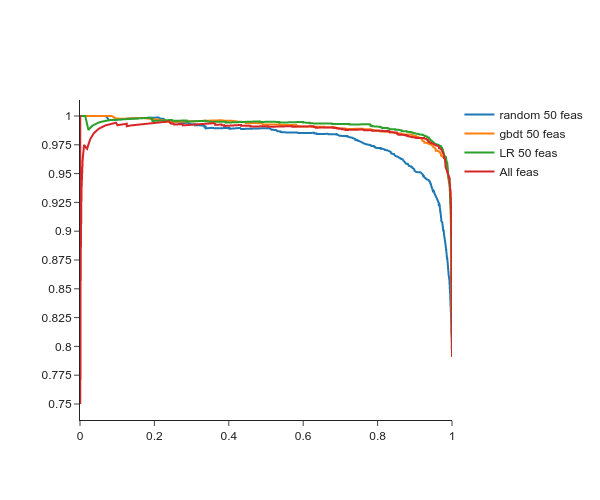

In [30]:
from IPython.display import display,Image
fig = go.Figure()
fig.add_scatter(x=prauc_curve1['V1'],y=prauc_curve1['V2'],mode='lines',name='random 50 feas')
fig.add_scatter(x=prauc_curve2['V1'],y=prauc_curve2['V2'],mode='lines',name='gbdt 50 feas')
fig.add_scatter(x=prauc_curve3['V1'],y=prauc_curve3['V2'],mode='lines',name='LR 50 feas')
fig.add_scatter(x=prauc_curve4['V1'],y=prauc_curve4['V2'],mode='lines',name='All feas')
fig.layout.template='simple_white'
fig.layout.width = 600
fig.layout.height = 500
#fig.layout.xaxis.dtick = 0.025
fig.layout.yaxis.dtick = 0.025
display(Image(fig.to_image()))
fig.write_image('./tmp.pdf')

In [102]:
copy_train = reduced_data.reindex(columns=random_gbdt).fillna(0)
larger_c = []
for _ in tqdm(range(50)):
    _df = each_eval(copy_train, y_bin, 5,model_f=GBDT_m)
    _df = _df.T
    larger_c.append(_df)
_df_Rggbdt = pd.concat(larger_c, axis=1)
larger_c = []
for _ in tqdm(range(50)):
    _df = each_eval(copy_train, y_bin, 5,model_f=LR_m_ll)
    _df = _df.T
    larger_c.append(_df)
_df_Rglr = pd.concat(larger_c, axis=1)
larger_c = []
for _ in tqdm(range(50)):
    _df = each_eval(copy_train, y_bin, 5,model_f=svmlinear_m)
    _df = _df.T
    larger_c.append(_df)
_df_Rgsvm = pd.concat(larger_c, axis=1)

100%|██████████| 50/50 [02:12<00:00,  2.66s/it]


In [86]:
copy_train = reduced_data.reindex(columns=random_svm).fillna(0)
larger_c = []
for _ in tqdm(range(50)):
    _df = each_eval(copy_train, y_bin, 5,model_f=GBDT_m)
    _df = _df.T
    larger_c.append(_df)
_df_Rsgbdt = pd.concat(larger_c, axis=1)
larger_c = []
for _ in tqdm(range(50)):
    _df = each_eval(copy_train, y_bin, 5,model_f=LR_m_ll)
    _df = _df.T
    larger_c.append(_df)
_df_Rslr = pd.concat(larger_c, axis=1)
larger_c = []
for _ in tqdm(range(50)):
    _df = each_eval(copy_train, y_bin, 5,model_f=svmlinear_m)
    _df = _df.T
    larger_c.append(_df)
_df_Rssvm = pd.concat(larger_c, axis=1)

100%|██████████| 50/50 [04:43<00:00,  5.67s/it]


In [96]:
copy_train = reduced_data.reindex(columns=random_lr).fillna(0)
larger_c = []
for _ in tqdm(range(50)):
    _df = each_eval(copy_train, y_bin, 5,model_f=GBDT_m)
    _df = _df.T
    larger_c.append(_df)
_df_Rlgbdt = pd.concat(larger_c, axis=1)
larger_c = []
for _ in tqdm(range(50)):
    _df = each_eval(copy_train, y_bin, 5,model_f=LR_m_ll)
    _df = _df.T
    larger_c.append(_df)
_df_Rllr = pd.concat(larger_c, axis=1)
larger_c = []
for _ in tqdm(range(50)):
    _df = each_eval(copy_train, y_bin, 5,model_f=svmlinear_m)
    _df = _df.T
    larger_c.append(_df)
_df_Rlsvm = pd.concat(larger_c, axis=1)

100%|██████████| 50/50 [02:34<00:00,  3.09s/it]


## exchange to validate

In [42]:
gbdt_selected = list(fulldf_GBDT.index[:-3])
copy_train = reduced_data.reindex(columns=gbdt_selected).fillna(0)
larger_c = []
for _ in tqdm(range(50)):
    _df = each_eval(copy_train, y_bin, 5,model_f=LR_m_ll)
    _df = _df.T
    larger_c.append(_df)
fulldf_gbdt_selected_LR = pd.concat(larger_c, axis=1)

100%|██████████| 50/50 [00:18<00:00,  2.77it/s]


In [43]:
gbdt_selected = list(fulldf_GBDT.index[:-3])
copy_train = reduced_data.reindex(columns=gbdt_selected).fillna(0)
larger_c = []
for _ in tqdm(range(50)):
    _df = each_eval(copy_train, y_bin, 5,model_f=svmlinear_m)
    _df = _df.T
    larger_c.append(_df)
fulldf_gbdt_selected_SVM = pd.concat(larger_c, axis=1)

100%|██████████| 50/50 [02:13<00:00,  2.67s/it]


In [87]:
import random

svm_selected = list(fulldf_SVM.index[:-3])
copy_train = reduced_data.reindex(columns=svm_selected)
larger_c = []
for _ in tqdm(range(50)):
    _df = each_eval(copy_train, y_bin, 5,model_f=GBDT_m)
    _df = _df.T
    larger_c.append(_df)
fulldf_svm_selected_GBDT = pd.concat(larger_c, axis=1)

100%|██████████| 50/50 [02:25<00:00,  2.92s/it]


In [88]:
svm_selected = list(fulldf_SVM.index[:-3])
copy_train = reduced_data.reindex(columns=svm_selected)
larger_c = []
for _ in tqdm(range(50)):
    _df = each_eval(copy_train, y_bin, 5,model_f=LR_m_ll)
    _df = _df.T
    larger_c.append(_df)
fulldf_svm_selected_LR = pd.concat(larger_c, axis=1)

100%|██████████| 50/50 [01:27<00:00,  1.76s/it]


In [47]:
LR_selected = list(fulldf_LR.index[:-3])
copy_train = reduced_data.reindex(columns=LR_selected)
larger_c = []
for _ in tqdm(range(50)):
    _df = each_eval(copy_train, y_bin, 5,model_f=GBDT_m)
    _df = _df.T
    larger_c.append(_df)
fulldf_LR_selected_gbdt = pd.concat(larger_c, axis=1)

100%|██████████| 50/50 [00:19<00:00,  2.59it/s]


In [48]:
LR_selected = list(fulldf_LR.index[:-3])
copy_train = reduced_data.reindex(columns=LR_selected)
larger_c = []
for _ in tqdm(range(50)):
    _df = each_eval(copy_train, y_bin, 5,model_f=svmlinear_m)
    _df = _df.T
    larger_c.append(_df)
fulldf_LR_selected_SVM = pd.concat(larger_c, axis=1)

100%|██████████| 50/50 [02:00<00:00,  2.41s/it]


In [103]:
metric = 'acc'

merged_df = pd.DataFrame()
merged_df.loc[:,f'Random{len_svm_selected} (SVM)'] = list(_df_Rssvm.loc[metric,:])
merged_df.loc[:,f'Random{len_svm_selected} (GBDT)'] = list(_df_Rsgbdt.loc[metric,:])
merged_df.loc[:,f'Random{len_svm_selected} (LR)'] = list(_df_Rslr.loc[metric,:])

merged_df.loc[:,f'Random{len_gbdt_selected} (SVM)'] = list(_df_Rgsvm.loc[metric,:])
merged_df.loc[:,f'Random{len_gbdt_selected} (GBDT)'] = list(_df_Rggbdt.loc[metric,:])
merged_df.loc[:,f'Random{len_gbdt_selected} (LR)'] = list(_df_Rglr.loc[metric,:])

merged_df.loc[:,f'Random{len_lr_selected} (SVM)'] = list(_df_Rlsvm.loc[metric,:])
merged_df.loc[:,f'Random{len_lr_selected} (GBDT)'] = list(_df_Rlgbdt.loc[metric,:])
merged_df.loc[:,f'Random{len_lr_selected} (LR)'] = list(_df_Rllr.loc[metric,:])

merged_df.loc[:,f'SVM Selected{len_svm_selected} (SVM)'] = list(fulldf_SVM.loc[metric,:])
merged_df.loc[:,f'SVM Selected{len_svm_selected} (GBDT)'] = list(fulldf_svm_selected_GBDT.loc[metric,:])
merged_df.loc[:,f'SVM Selected{len_svm_selected} (LR)'] = list(fulldf_svm_selected_LR.loc[metric,:])


merged_df.loc[:,f'GBDT Selected{len_gbdt_selected} (SVM)'] = list(fulldf_gbdt_selected_SVM.loc[metric,:])
merged_df.loc[:,f'GBDT Selected{len_gbdt_selected} (GBDT)'] = list(fulldf_GBDT.loc[metric,:])
merged_df.loc[:,f'GBDT Selected{len_gbdt_selected} (LR)'] = list(fulldf_gbdt_selected_LR.loc[metric,:])


merged_df.loc[:,f'LR Selected{len_lr_selected} (SVM)'] = list(fulldf_LR_selected_SVM.loc[metric,:])
merged_df.loc[:,f'LR Selected{len_lr_selected} (GBDT)'] = list(fulldf_LR_selected_gbdt.loc[metric,:])
merged_df.loc[:,f'LR Selected{len_lr_selected} (LR)'] = list(fulldf_LR.loc[metric,:])


In [23]:
# merged_df = pd.read_csv(f'/mnt/ivy/thliao/project/ML_oxygen/training_sets/processed_data/CBdist_based_filter/final_validation/top{len_gbdt_selected}_vs_top{len_svm_selected}.tsv',sep='\t',index_col=0)
# merged_df
# merged_df.loc[:,f'LR Selected{len_gbdt_selected} (SVM)'] = list(fulldf_LR_selected_SVM.loc['acc',:])
# merged_df.loc[:,f'LR Selected{len_gbdt_selected} (GBDT)'] = list(fulldf_LR_selected_gbdt.loc['acc',:])
# merged_df.loc[:,f'LR Selected{len_gbdt_selected} (LR)'] = list(fulldf_LR.loc['acc',:])
# merged_df.loc[:,f'Random{len_svm_selected} (SVM)'] = list(_df_Rssvm.loc['acc',:])

In [98]:
merged_df.to_csv('/mnt/ivy/thliao/project/ML_oxygen/training_sets/processed_data/CBdist_based_filter/final_validation/3selected_feas_comparisons.tsv',sep='\t',index=0)

In [8]:
merged_df = pd.read_csv('/mnt/ivy/thliao/project/ML_oxygen/training_sets/processed_data/CBdist_based_filter/final_validation/3selected_feas_comparisons.tsv',sep='\t',index_col=0)

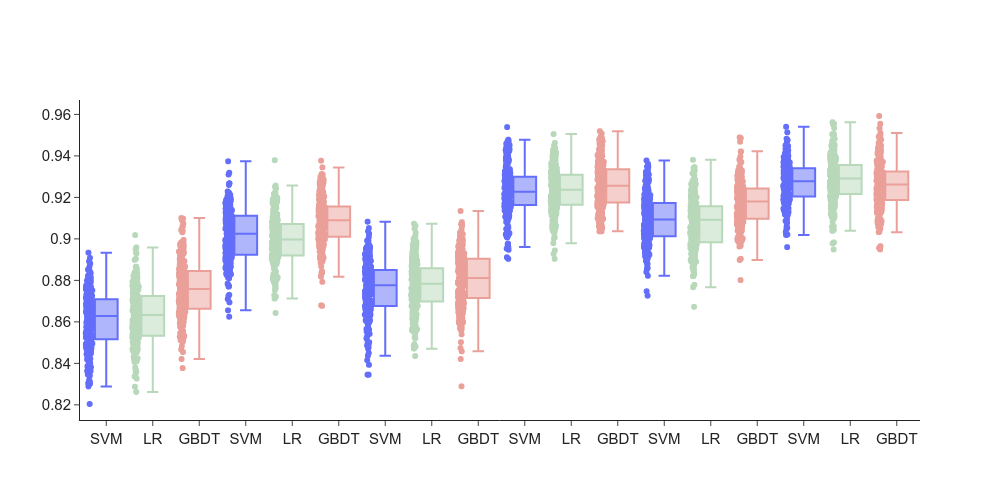

In [105]:
# per_df = pd.read_csv(f'/mnt/ivy/thliao/project/ML_oxygen/training_sets/processed_data/CBdist_based_filter/final_validation/top{len_gbdt_selected}_vs_top{len_svm_selected}.tsv',sep='\t')
per_df = merged_df


# c_mapping_d = {
#     f"Random{len_svm_selected} (SVM)": "#636efa",
#     f"Random{len_svm_selected} (LR)": "#636efa",
#     f"Random{len_svm_selected} (GBDT)": "#636efa",

#     f"Random{len_gbdt_selected} (SVM)": "#a4adf8",
#     f"Random{len_gbdt_selected} (LR)": "#a4adf8",
#     f"Random{len_gbdt_selected} (GBDT)": "#a4adf8",
    
#     f"GBDT Selected{len_gbdt_selected} (SVM)": "#eaa098",
#     f"GBDT Selected{len_gbdt_selected} (LR)": "#eaa098",
#     f"GBDT Selected{len_gbdt_selected} (GBDT)": "#eaa098",
    
#     f"SVM Selected{len_svm_selected} (SVM)": "#b8d8ba",
#     f"SVM Selected{len_svm_selected} (GBDT)": "#b8d8ba",
#     f"SVM Selected{len_svm_selected} (LR)": "#b8d8ba",
    
#     f"LR Selected{len_lr_selected} (SVM)": "#d9dbbc",
#     f"LR Selected{len_lr_selected} (LR)": "#d9dbbc",
#     f"LR Selected{len_lr_selected} (GBDT)": "#d9dbbc",   
# }


c_mapping_d = {

    f"Random{len_gbdt_selected} (SVM)": "#636efa",
    f"Random{len_gbdt_selected} (LR)": "#b8d8ba",
    f"Random{len_gbdt_selected} (GBDT)": "#eaa098",
    f"Random{len_svm_selected} (SVM)": "#636efa",
    f"Random{len_svm_selected} (LR)": "#b8d8ba",
    f"Random{len_svm_selected} (GBDT)": "#eaa098",
    f"Random{len_lr_selected} (SVM)": "#636efa",
    f"Random{len_lr_selected} (LR)": "#b8d8ba",
    f"Random{len_lr_selected} (GBDT)": "#eaa098",

    f"GBDT Selected{len_gbdt_selected} (SVM)": "#636efa",
    f"GBDT Selected{len_gbdt_selected} (LR)": "#b8d8ba",
    f"GBDT Selected{len_gbdt_selected} (GBDT)": "#eaa098",
    
    f"SVM Selected{len_svm_selected} (SVM)": "#636efa",
    f"SVM Selected{len_svm_selected} (LR)": "#b8d8ba",
     f"SVM Selected{len_svm_selected} (GBDT)": "#eaa098",
    
    f"LR Selected{len_lr_selected} (SVM)": "#636efa",
    f"LR Selected{len_lr_selected} (LR)": "#b8d8ba",
    f"LR Selected{len_lr_selected} (GBDT)": "#eaa098",   
}


per_df = per_df.reindex(columns=c_mapping_d.keys())
fig = go.Figure()
for name,col in per_df.iteritems():
    c = c_mapping_d[name]
    fig.add_box(y=col,name=name,
           boxpoints='all',
                marker={'color':c},showlegend=False
               )
fig.update_layout(height=500,width=1000,template='simple_white',
                 xaxis_tickvals = list(c_mapping_d.keys()),
                 xaxis_ticktext = [_.split('(')[-1].strip(')') for _ in c_mapping_d.keys()],
                 xaxis_tickmode = "array",
                  font_size=15,
                 )
display(Image(fig.to_image()))
#.show()
fig.write_image('/mnt/ivy/thliao/project/ML_oxygen/training_sets/processed_data/CBdist_based_filter/selectedFea_comparisons.pdf')

### functional classifications

In [5]:
from bin.other_convertor.classify_kos import *

In [6]:
sig_ko_list = list(fulldf_GBDT.index[:-2]) + list(fulldf_SVM.index[:-2])

In [7]:
br_kos = ko_classified_br(sig_ko_list)
md_kos = ko_classified_module(sig_ko_list)
md2info = get_md_infos(md_kos.keys())
info_kos = get_ko_infos(sig_ko_list)
infos = get_br_info(br_kos)

100%|██████████| 6/6 [00:00<00:00, 761.63it/s]


In [8]:
sig_kos_df = pd.concat(infos, axis=0)
sig_kos_df.loc[:, 'des'] = [info_kos.get(_, '') for _ in sig_kos_df.index]

In [15]:
sig_kos_df.loc[list(fulldf_GBDT.index[:-2]),:].to_excel('/mnt/ivy/thliao/project/ML_oxygen/training_sets/processed_data/CBdist_based_filter/top50_anno.xlsx')
sig_kos_df.loc[list(fulldf_SVM.index[:-2]),:].to_excel('/mnt/ivy/thliao/project/ML_oxygen/training_sets/processed_data/CBdist_based_filter/top180_anno.xlsx')

In [16]:
with open('/mnt/ivy/thliao/project/ML_oxygen/training_sets/processed_data/CBdist_based_filter/top50.txt','w') as f1:
    f1.write('\n'.join(fulldf_GBDT.index[:-2]))
with open('/mnt/ivy/thliao/project/ML_oxygen/training_sets/processed_data/CBdist_based_filter/top180.txt','w') as f1:
    f1.write('\n'.join(fulldf_SVM.index[:-2]))

In [39]:
ofile = "/mnt/ivy/thliao/project/ML_oxygen/training_sets/processed_data/CBdist_based_filter/selected_performance_LinearSVM.pdf"
fig.write_image(ofile)

# gene distributions among different phenotypes

In [ ]:
_df = pd.DataFrame(X[top50].sum(1))
_df.colmns=['x']
_df.loc[:,'p'] = [genome2oxy_bin[_] for _ in _df.index]
fig = px.histogram(_df, x=0, color="p")
fig.show()

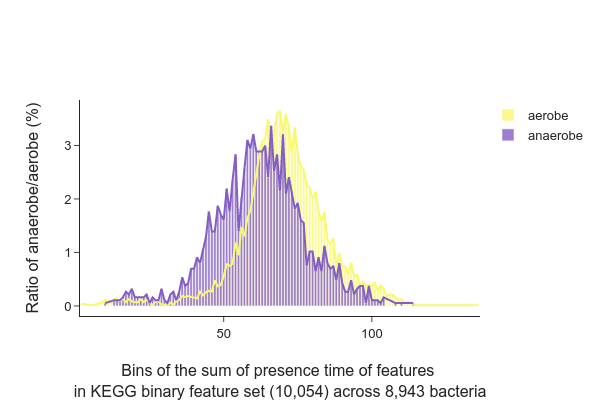

In [28]:
target_genes = list(fulldf_SVM.index[:-2])
fig = go.Figure()
x1 = X.loc[y_bin==1,target_genes].sum(1)
c = {k:v/len(x1)*100 for k,v in Counter(x1).items()}
data = sorted(c.items())
x,y = [_[0] for _ in data],[_[1] for _ in data]
fig.add_bar(x=x,y=y,name='aerobe',marker={'color':"#f9f871"},opacity=0.8)
# _f = ff.create_distplot([list(c.keys())], ['a'], bin_size=[1])
fig.add_scatter(x=x,y=y,name='aerobe',mode='lines',showlegend=False,marker={'color':"#f9f871"})
x1 = X.loc[y_bin==0,target_genes].sum(1)
c = {k:v/len(x1)*100 for k,v in Counter(x1).items()}
data = sorted(c.items())
x,y = [_[0] for _ in data],[_[1] for _ in data]
fig.add_scatter(x=x,y=y,name='anaerobe',mode='lines',showlegend=False,marker={'color':"#845ec2"},)
fig.add_bar(x=x,y=y,name='anaerobe',marker={'color':"#845ec2"},opacity=0.8)

fig.update_layout(barmode='overlay', height=400,width=600,template='simple_white',font_size=13)
fig.layout.xaxis.title = 'Bins of the sum of presence time of features <Br>in KEGG binary feature set (10,054) across 8,943 bacteria'
fig.layout.yaxis.title = 'Ratio of anaerobe/aerobe (%)'
display(Image(fig.to_image()))
fig.write_image('/mnt/ivy/thliao/project/ML_oxygen/training_sets/processed_data/CBdist_based_filter/SVM180_geneDist.pdf',)

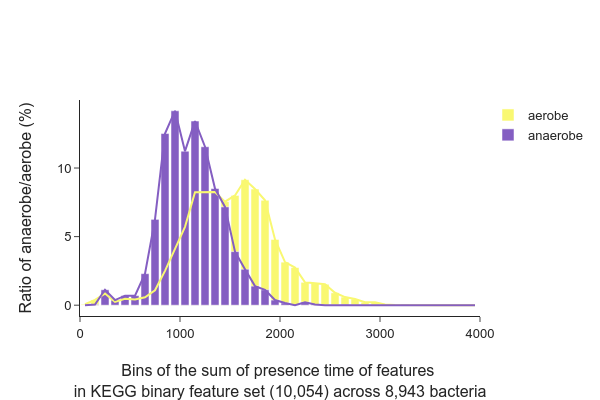

In [29]:
fig = go.Figure()
ir = pd.interval_range(start=0, freq=100, end=4000, closed='left')
x1 = X.loc[y_bin==1,:].sum(1)
a = pd.cut(x1, bins=ir)
c = {k:v/len(x1)*100 for k,v in pd.DataFrame(a).groupby(0).size().to_dict().items()}
assert abs(sum(list(c.values()))-100)<1e-6

data = sorted(c.items())
x,y = [_[0].mid for _ in data],[_[1] for _ in data]
fig.add_bar(x=x,y=y,name='aerobe',marker={'color':"#f9f871"})
fig.add_scatter(x=x,y=y,name='aerobe',mode='lines',showlegend=False,marker={'color':"#f9f871"},)

x1 = X.loc[y_bin==0,:].sum(1)
a = pd.cut(x1, bins=ir)
c = {k:v/len(x1)*100 for k,v in pd.DataFrame(a).groupby(0).size().to_dict().items()}
assert abs(sum(list(c.values()))-100)<1e-6
data = sorted(c.items())
x,y = [_[0].mid for _ in data],[_[1] for _ in data]
fig.add_scatter(x=x,y=y,name='anaerobe',mode='lines',showlegend=False,marker={'color':"#845ec2"},)
fig.add_bar(x=x,y=y,name='anaerobe',marker={'color':"#845ec2"})

fig.update_layout(barmode='overlay', height=400,width=600,template='simple_white',font_size=13)
fig.layout.xaxis.title = 'Bins of the sum of presence time of features <Br>in KEGG binary feature set (10,054) across 8,943 bacteria'
fig.layout.yaxis.title = 'Ratio of anaerobe/aerobe (%)'
display(Image(fig.to_image()))
fig.write_image('/mnt/ivy/thliao/project/ML_oxygen/training_sets/processed_data/CBdist_based_filter/Full_geneDist.pdf',)
#fig.show()

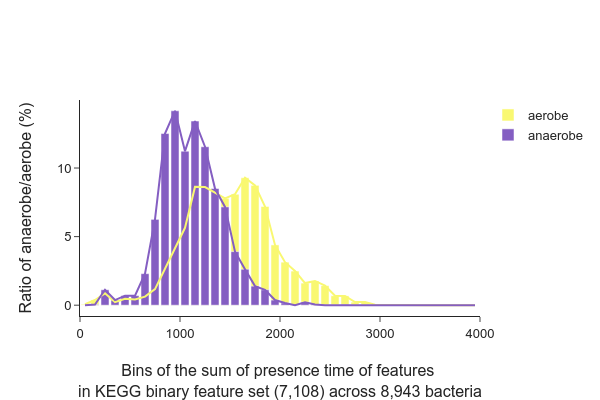

In [114]:
fig = go.Figure()
ir = pd.interval_range(start=0, freq=100, end=4000, closed='left')
x1 = reduced_data.loc[y_bin==1,:].sum(1)
a = pd.cut(x1, bins=ir)
c = {k:v/len(x1)*100 for k,v in pd.DataFrame(a).groupby(0).size().to_dict().items()}
assert abs(sum(list(c.values()))-100)<1e-6

data = sorted(c.items())
x,y = [_[0].mid for _ in data],[_[1] for _ in data]
fig.add_bar(x=x,y=y,name='aerobe',marker={'color':"#f9f871"})
fig.add_scatter(x=x,y=y,name='aerobe',mode='lines',showlegend=False,marker={'color':"#f9f871"},)

x1 = X.loc[y_bin==0,:].sum(1)
a = pd.cut(x1, bins=ir)
c = {k:v/len(x1)*100 for k,v in pd.DataFrame(a).groupby(0).size().to_dict().items()}
assert abs(sum(list(c.values()))-100)<1e-6
data = sorted(c.items())
x,y = [_[0].mid for _ in data],[_[1] for _ in data]
fig.add_scatter(x=x,y=y,name='anaerobe',mode='lines',showlegend=False,marker={'color':"#845ec2"},)
fig.add_bar(x=x,y=y,name='anaerobe',marker={'color':"#845ec2"})

fig.update_layout(barmode='overlay', height=400,width=600,template='simple_white',font_size=13)
fig.layout.xaxis.title = 'Bins of the sum of presence time of features <Br>in KEGG binary feature set (7,108) across 8,943 bacteria'
fig.layout.yaxis.title = 'Ratio of anaerobe/aerobe (%)'
display(Image(fig.to_image()))
fig.write_image('/mnt/ivy/thliao/project/ML_oxygen/training_sets/processed_data/CBdist_based_filter/CBreduced_geneDist.pdf',)
#fig.show()

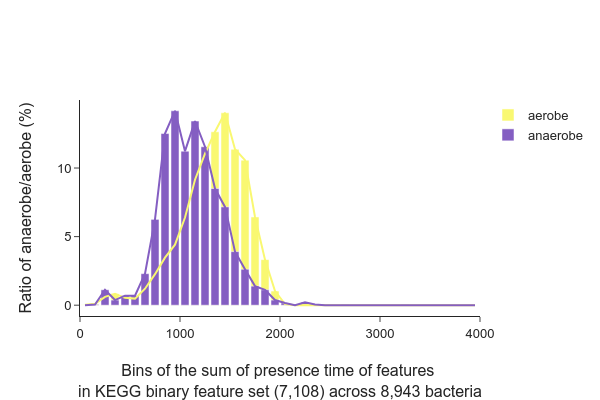

In [71]:

fig = go.Figure()
ir = pd.interval_range(start=0, freq=100, end=4000, closed='left')
x1 = reduced_pfam.loc[y_bin==1,:].sum(1)
a = pd.cut(x1, bins=ir)
c = {k:v/len(x1)*100 for k,v in pd.DataFrame(a).groupby(0).size().to_dict().items()}
assert abs(sum(list(c.values()))-100)<1e-6

data = sorted(c.items())
x,y = [_[0].mid for _ in data],[_[1] for _ in data]
fig.add_bar(x=x,y=y,name='aerobe',marker={'color':"#f9f871"})
fig.add_scatter(x=x,y=y,name='aerobe',mode='lines',showlegend=False,marker={'color':"#f9f871"},)

x1 = X.loc[y_bin==0,:].sum(1)
a = pd.cut(x1, bins=ir)
c = {k:v/len(x1)*100 for k,v in pd.DataFrame(a).groupby(0).size().to_dict().items()}
assert abs(sum(list(c.values()))-100)<1e-6
data = sorted(c.items())
x,y = [_[0].mid for _ in data],[_[1] for _ in data]
fig.add_scatter(x=x,y=y,name='anaerobe',mode='lines',showlegend=False,marker={'color':"#845ec2"},)
fig.add_bar(x=x,y=y,name='anaerobe',marker={'color':"#845ec2"})
fig.update_layout(barmode='overlay', height=400,width=600,template='simple_white',font_size=13)
fig.layout.xaxis.title = 'Bins of the sum of presence time of features <Br>in KEGG binary feature set (7,108) across 8,943 bacteria'
fig.layout.yaxis.title = 'Ratio of anaerobe/aerobe (%)'
display(Image(fig.to_image()))
#fig.write_image('/mnt/ivy/thliao/project/ML_oxygen/training_sets/processed_data/CBdist_based_filter/CBreduced_geneDist.pdf',)
#fig.show()


In [72]:
fig.write_image('/mnt/ivy/thliao/project/ML_oxygen/training_sets/processed_data/CBdist_based_filter/PFAM_CBreduced_geneDist.pdf',)

In [ ]:
fig = go.Figure()
ir = pd.interval_range(start=0, freq=100, end=4000, closed='left')
x1 = reduced_data.loc[y_bin==1,:].sum(1)
a = pd.cut(x1, bins=ir)
c = {k:v/len(x1)*100 for k,v in pd.DataFrame(a).groupby(0).size().to_dict().items()}
assert abs(sum(list(c.values()))-100)<1e-6

data = sorted(c.items())
x,y = [_[0].mid for _ in data],[_[1] for _ in data]
fig.add_bar(x=x,y=y,name='aerobe',marker={'color':"#f9f871"})
fig.add_scatter(x=x,y=y,name='aerobe',mode='lines',showlegend=False,marker={'color':"#f9f871"},)

x1 = X.loc[y_bin==0,:].sum(1)
a = pd.cut(x1, bins=ir)
c = {k:v/len(x1)*100 for k,v in pd.DataFrame(a).groupby(0).size().to_dict().items()}
assert abs(sum(list(c.values()))-100)<1e-6
data = sorted(c.items())
x,y = [_[0].mid for _ in data],[_[1] for _ in data]
fig.add_scatter(x=x,y=y,name='anaerobe',mode='lines',showlegend=False,marker={'color':"#845ec2"},)
fig.add_bar(x=x,y=y,name='anaerobe',marker={'color':"#845ec2"})

fig.update_layout(barmode='overlay', height=400,width=600,template='simple_white',font_size=13)
fig.layout.xaxis.title = 'Bins of the sum of presence time of features <Br>in KEGG binary feature set (7,108) across 8,943 bacteria'
fig.layout.yaxis.title = 'Ratio of anaerobe/aerobe (%)'
display(Image(fig.to_image()))
fig.write_image('/mnt/ivy/thliao/project/ML_oxygen/training_sets/processed_data/CBdist_based_filter/CBreduced_geneDist.pdf',)
#fig.show()

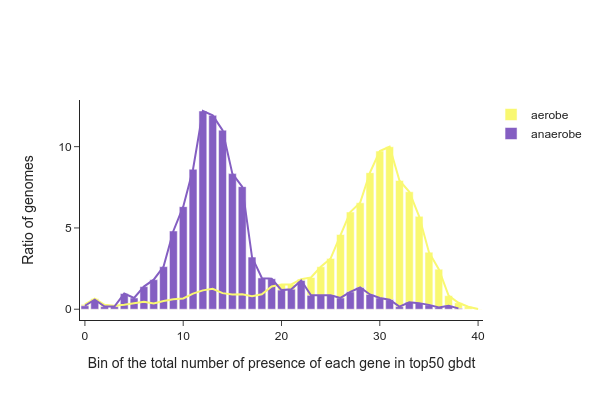

In [65]:
import plotly.figure_factory as ff
#_f = ff.create_distplot([list(c.keys())], ['a'], bin_size=[1])

target_genes = list(fulldf_GBDT.index)[:-2]
fig = go.Figure()
x1 = X.loc[y_bin==1,target_genes].sum(1)
c = {k:v/len(x1)*100 for k,v in Counter(x1).items()}
data = sorted(c.items())
x,y = [_[0] for _ in data],[_[1] for _ in data]
fig.add_bar(x=x,y=y,name='aerobe',marker={'color':"#f9f871"},)
# _f = ff.create_distplot([list(c.keys())], ['a'], bin_size=[1])
fig.add_scatter(x=x,y=y,name='aerobe',mode='lines',showlegend=False,marker={'color':"#f9f871"},)
x1 = X.loc[y_bin==0,target_genes].sum(1)
c = {k:v/len(x1)*100 for k,v in Counter(x1).items()}
data = sorted(c.items())
x,y = [_[0] for _ in data],[_[1] for _ in data]
fig.add_scatter(x=x,y=y,name='anaerobe',mode='lines',showlegend=False,marker={'color':"#845ec2"},)
fig.add_bar(x=x,y=y,name='anaerobe',marker={'color':"#845ec2"})

# _f = ff.create_distplot([list(c.keys())], ['a'], bin_size=[1])
# fig.add_scatter(x=_f.data[1]['x'],y=_f.data[1]['y'],name='anaerobe',mode='lines',showlegend=False,marker={'color':"#845ec2"},)

fig.update_layout(barmode='overlay', height=400,width=600,template='simple_white')
fig.layout.xaxis.title = 'Bin of the total number of presence of each gene in top50 gbdt '
fig.layout.yaxis.title = 'Ratio of genomes'
display(Image(fig.to_image()))
fig.write_image('/mnt/ivy/thliao/project/ML_oxygen/training_sets/processed_data/CBdist_based_filter/top50_geneDist.pdf',)

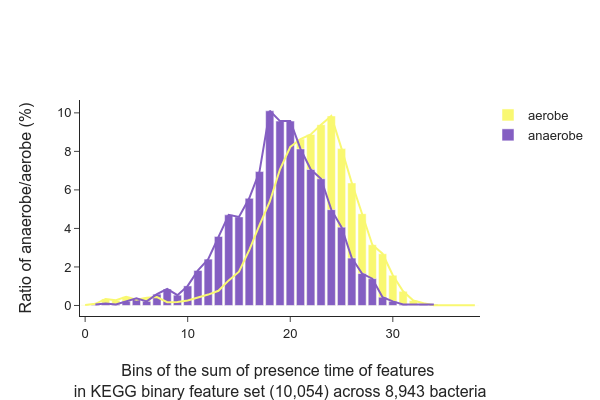

In [27]:
import plotly.figure_factory as ff
#_f = ff.create_distplot([list(c.keys())], ['a'], bin_size=[1])

target_genes = list(fulldf_LR.index)[:-2]
fig = go.Figure()
x1 = X.loc[y_bin==1,target_genes].sum(1)
c = {k:v/len(x1)*100 for k,v in Counter(x1).items()}
data = sorted(c.items())
x,y = [_[0] for _ in data],[_[1] for _ in data]
fig.add_bar(x=x,y=y,name='aerobe',marker={'color':"#f9f871"},)
# _f = ff.create_distplot([list(c.keys())], ['a'], bin_size=[1])
fig.add_scatter(x=x,y=y,name='aerobe',mode='lines',showlegend=False,marker={'color':"#f9f871"},)
x1 = X.loc[y_bin==0,target_genes].sum(1)
c = {k:v/len(x1)*100 for k,v in Counter(x1).items()}
data = sorted(c.items())
x,y = [_[0] for _ in data],[_[1] for _ in data]
fig.add_scatter(x=x,y=y,name='anaerobe',mode='lines',showlegend=False,marker={'color':"#845ec2"},)
fig.add_bar(x=x,y=y,name='anaerobe',marker={'color':"#845ec2"})

# _f = ff.create_distplot([list(c.keys())], ['a'], bin_size=[1])
# fig.add_scatter(x=_f.data[1]['x'],y=_f.data[1]['y'],name='anaerobe',mode='lines',showlegend=False,marker={'color':"#845ec2"},)

fig.update_layout(barmode='overlay', height=400,width=600,template='simple_white',font_size=13)
fig.layout.xaxis.title = 'Bins of the sum of presence time of features <Br>in KEGG binary feature set (10,054) across 8,943 bacteria'
fig.layout.yaxis.title = 'Ratio of anaerobe/aerobe (%)'
display(Image(fig.to_image()))
fig.write_image('/mnt/ivy/thliao/project/ML_oxygen/training_sets/processed_data/CBdist_based_filter/LR50_geneDist.pdf',)

# dis among different taxa

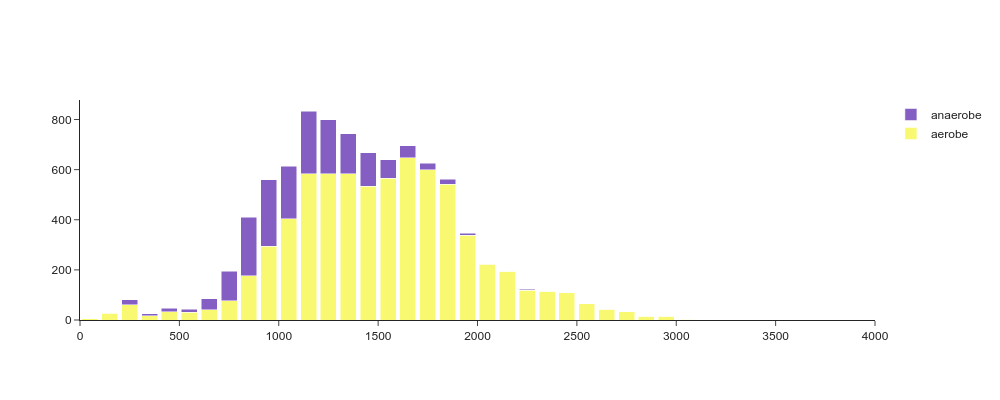

In [37]:
fig = go.Figure()
ir = pd.interval_range(start=0, freq=100, end=4000, closed='left')
x1 = X.loc[y_bin==1,:].sum(1)
a = pd.cut(x1, bins=ir)
c = pd.DataFrame(a).groupby(0).size().to_dict()
fig.add_bar(x=[_.mid for _ in c.keys()],y=list(c.values()),name='aerobe',marker={'color':"#f9f871"})

x1 = X.loc[y_bin==0,:].sum(1)
a = pd.cut(x1, bins=ir)
c = pd.DataFrame(a).groupby(0).size().to_dict()
fig.add_bar(x=[_.mid for _ in c.keys()],y=list(c.values()),name='anaerobe',marker={'color':"#845ec2"})
fig.layout.barmode='stack'
fig.layout.height = 400
fig.layout.width = 1000
fig.layout.template = 'simple_white'
display(Image(fig.to_image()))
#fig.show()

# Evaluate traitar performance

In [20]:
def get_traitar_acc(X_train_large, y_train_large,X_test_large, y_test_large,ignore=True):
    _df = sub_traitar_df.loc[X_test_large.index,:]
    _df.loc[(_df.loc[:,["Aerobe","Facultative"]]>0).any(1) & (_df.loc[:,["Anaerobe"]]==0).all(1),'predicted'] = 1
    _df.loc[(_df.loc[:,["Anaerobe"]]>0).any(1) & (_df.loc[:,["Aerobe","Facultative"]]==0).all(1),'predicted'] = 0
    _df.loc[:,'true'] = y_test_large
    # make those as negative predictions
    if ignore:
        _df = _df.loc[~_df['predicted'].isna(),:]
    else:
        _df.loc[_df['predicted'].isna(),'predicted'] = 1- _df.loc[_df['predicted'].isna(),'true']
    accuracy = metrics.balanced_accuracy_score(_df['true'],
                                               _df['predicted'])
    return None,_df['predicted'],None,accuracy,None
# model_def['traitar'] = lambda a,b,c,d: get_traitar_acc(a,b,c,d,ignore=True)
# model_def['traitar-masked'] = lambda a,b,c,d: get_traitar_acc(a,b,c,d,ignore=False)

In [133]:

a = predicted_df.loc[(predicted_df.loc[:,["Aerobe","Facultative"]]>0).any(1) & (predicted_df.loc[:,["Anaerobe"]]>0).all(1),:]

_df = predicted_df.copy()
b = _df.loc[(_df.loc[:,["Aerobe","Facultative"]]>0).any(1) & (_df.loc[:,["Anaerobe"]]==0).all(1),:]

c = _df.loc[(_df.loc[:,["Anaerobe"]]>0).any(1) & (_df.loc[:,["Aerobe","Facultative"]]==0).all(1),:]


In [134]:
d = set(_df.index).difference(a.index).difference(b.index).difference(c.index)

In [ ]:
_df.index[(_df.loc[:,["Anaerobe","Aerobe","Facultative"]]==0).all(1)]

In [135]:
_df.loc[d,["Anaerobe","Aerobe","Facultative"]]

,Anaerobe,Aerobe,Facultative
GCA_002723475.1,0.0,0.0,0.0
GCA_002220775.1,0.0,0.0,0.0
GCA_001714745.1,0.0,0.0,0.0
GCA_003475915.1,0.0,0.0,0.0
GCA_009469755.1,0.0,0.0,0.0
...,...,...,...
GCA_001543875.1,0.0,0.0,0.0
GCA_004368235.1,0.0,0.0,0.0
GCA_000430805.1,0.0,0.0,0.0
GCA_013201705.1,0.0,0.0,0.0


In [122]:
1454+6748+328

8530

In [79]:
# traitar predicted results
predicted_df = pd.read_csv('/mnt/ivy/thliao/project/ML_oxygen/comparative/traitar/full_o/phenotype_prediction/predictions_majority-vote_combined.txt',sep='\t',index_col=0)
predicted_df = predicted_df.loc[X.index,:]
aerobe_cols = ["Aerobe",
               "Anaerobe",
               "Capnophilic",
               "Facultative"]

sub_traitar_df = predicted_df.loc[:,aerobe_cols]
sub_traitar_df.loc[X.index,'true category'] = y_bin

In [90]:
for k,v in name2times.items():
    print(np.mean(v))

3.4916000000000005
0.052500000000000005
0.7512800000000001
0.07088000000000001
0.60514


In [ ]:
gbdt_selected = list(fulldf_GBDT.index[:-2])
gbdt_selected

In [91]:

name2acc = defaultdict(list)
name2AUC = defaultdict(list)
name2times = defaultdict(list)
for _ii in tqdm(list(range(50))):
    sssp = StratifiedShuffleSplit(n_splits=5)
    for samples_80, samples_20 in sssp.split(reduced_data,y_bin):
        # print("TRAIN:", train_index, "TEST:", test_index)
        X_train_large, X_test_large = reduced_data.iloc[samples_80, :], reduced_data.iloc[samples_20, :]
        y_train_large, y_test_large = y_bin[samples_80], y_bin[samples_20]
        _df = sub_traitar_df.loc[X_test_large.index,:]
        _df.loc[(_df.loc[:,["Aerobe","Facultative"]]>0).any(1) & (_df.loc[:,["Anaerobe"]]==0).all(1),'predicted'] = 1
        _df.loc[(_df.loc[:,["Anaerobe"]]>0).any(1) & (_df.loc[:,["Aerobe","Facultative"]]==0).all(1),'predicted'] = 0
        _df.loc[:,'true'] = y_test_large
        removed_ids = _df.index[_df['predicted'].isna()]
        _df = _df.loc[~_df['predicted'].isna(),:]
        accuracy = metrics.balanced_accuracy_score(_df['true'],
                                                   _df['predicted'])
        name2acc['traitar'].append(accuracy)
        rid_idx = X_test_large.index.isin(removed_ids)
        X_test_large = X_test_large.loc[~rid_idx,:]
        y_test_large = y_test_large[~rid_idx]
        for name in ['LR','linear','RF','GBDT','SVMlinear']:
            f = model_def[name]
            st = time.time()
            y_pred,y_pred_label,model,accuracy,auc = f(X_train_large.loc[:,gbdt_selected], y_train_large,
                                                       X_test_large.loc[:,gbdt_selected], y_test_large)
            used_time = time.time()-st
            name2acc[name].append(accuracy)
            name2times[name].append(round(used_time,4))
            if y_pred is not None:
                name2AUC[name].append(auc)
    

100%|██████████| 50/50 [11:24<00:00, 13.69s/it]


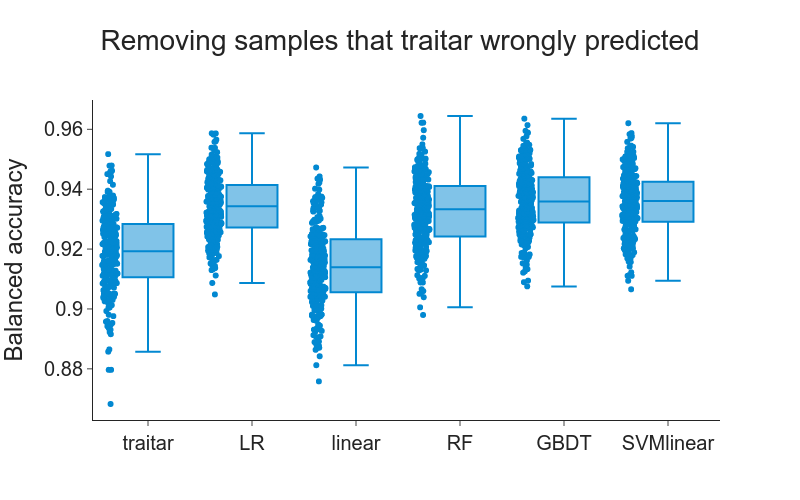

In [92]:
# using gbdt selected top50 features only
from IPython.display import Image,display
fig = go.Figure()
for mode,v in name2acc.items():
    fig.add_box(y=v,
                x=[ mode]*len(v),
                boxpoints='all',showlegend=False,marker={'color':"#0288D1"})

fig.update_layout(width=800,height=500,template='simple_white',font_size=20,yaxis_title='Balanced accuracy',
                 title_text="Removing samples that traitar wrongly predicted",title_x=0.5)
fig.write_image('/mnt/ivy/thliao/project/ML_oxygen/comparative/traitar/full_o/traitar_comparision1.pdf')

display(Image(fig.to_image()))

In [94]:

name2acc_with = defaultdict(list)
for _ii in tqdm(list(range(50))):
    sssp = StratifiedShuffleSplit(n_splits=5)
    for samples_80, samples_20 in sssp.split(reduced_data,y_bin):
        # print("TRAIN:", train_index, "TEST:", test_index)
        X_train_large, X_test_large = reduced_data.iloc[samples_80, :], reduced_data.iloc[samples_20, :]
        y_train_large, y_test_large = y_bin[samples_80], y_bin[samples_20]
        _df = sub_traitar_df.loc[X_test_large.index,:]
        _df.loc[(_df.loc[:,["Aerobe","Facultative"]]>0).any(1) & (_df.loc[:,["Anaerobe"]]==0).all(1),'predicted'] = 1
        _df.loc[(_df.loc[:,["Anaerobe"]]>0).any(1) & (_df.loc[:,["Aerobe","Facultative"]]==0).all(1),'predicted'] = 0
        _df.loc[:,'true'] = y_test_large
        removed_ids = _df.index[_df['predicted'].isna()]
        #_df = _df.loc[~_df['predicted'].isna(),:]
        _df.loc[_df['predicted'].isna(),'predicted'] = 1- _df.loc[_df['predicted'].isna(),'true']
        accuracy = metrics.balanced_accuracy_score(_df['true'],
                                                   _df['predicted'])
        name2acc_with['traitar'].append(accuracy)
        for name in ['LR','linear','RF','GBDT','SVMlinear']:
            f = model_def[name]
            y_pred,y_pred_label,model,accuracy,auc = f(X_train_large.loc[:,gbdt_selected], y_train_large,
                                                       X_test_large.loc[:,gbdt_selected], y_test_large)
            name2acc_with[name].append(accuracy)
    

100%|██████████| 50/50 [11:03<00:00, 13.27s/it]


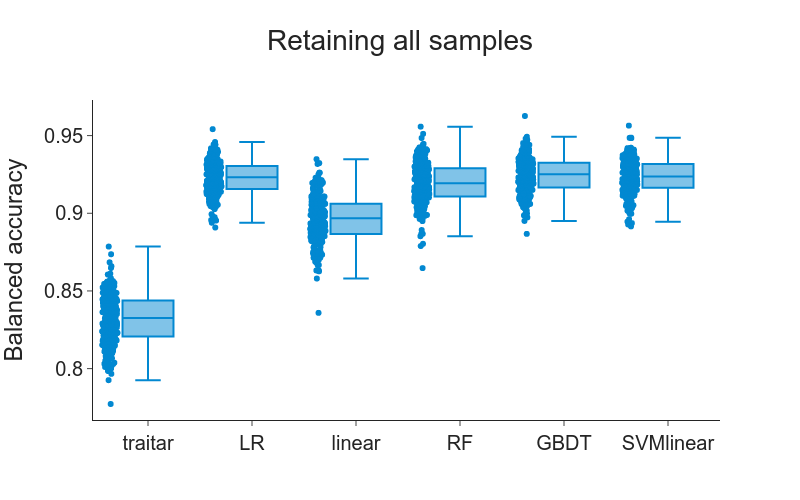

In [95]:
# using gbdt selected top50 features only
from IPython.display import Image,display
fig = go.Figure()
for mode,v in name2acc_with.items():
    fig.add_box(y=v,
                x=[ mode]*len(v),
                boxpoints='all',showlegend=False,marker={'color':"#0288D1"})
fig.update_layout(width=800,height=500,template='simple_white',font_size=20,yaxis_title='Balanced accuracy',
                 title_text="Retaining all samples",title_x=0.5)
#fig.show()
fig.write_image('/mnt/ivy/thliao/project/ML_oxygen/comparative/traitar/full_o/traitar_comparision2.pdf')

display(Image(fig.to_image()))

# NEE comparison

compare to Jabłońska, Jagoda, and Dan S. Tawfik. "The evolution of oxygen-utilizing enzymes suggests early biosphere oxygenation." Nature ecology & evolution 5.4 (2021): 442-448.

In [106]:
names = accession = ''
pfam_names = {}
for row in open('/mnt/maple/thliao/data/protein_db/Pfam.v33.1/Pfam-A.hmm'):
    row = row.strip()
    if row.startswith('DESC '):
        name = row.split(' ',1)[-1].strip() 
        pfam_names[accession] = name
        names = accession = ''         
    if row.startswith('ACC '):
        accession = row.split(' ')[-1].strip()


In [104]:
NEE_df = pd.read_excel("/mnt/ivy/thliao/project/ML_oxygen/prior/relevant/NEE results.xlsx")

NEE_df.columns = ["pid", "type"]

output_dir = f"/home-user/thliao/project/ML_oxygen/training_sets/processed_data"
pfam_bin_df = pd.read_csv(f"{output_dir}/pfam_anno.tab", sep="\t", index_col=0)
pfam_bin_df = pfam_bin_df.reindex(bac_ids)
NEE_df.loc[NEE_df.pid=='PF0426','pid'] = 'PF04261'

In [107]:
match_ids = {
    _.split(".")[0]: _
    for _ in pfam_names
    if _.split(".")[0] in set([k.strip(' ') for k in list(NEE_df["pid"])])
}
NEE_df.loc[:, "found_id"] = [match_ids.get(_.strip(), "") for _ in NEE_df["pid"]]
founding_NEE_ids = list(NEE_df.loc[(NEE_df['type']=='founding') & (NEE_df['found_id']!=''),'found_id'])
_founding_NEE_ids = list(NEE_df.loc[(NEE_df['type']=='founding'),'found_id'])
print(f"{len(founding_NEE_ids)}/{len(_founding_NEE_ids)}")


81/81


In [110]:

copy_train = pfam_bin_df.reindex(columns=founding_NEE_ids).fillna(0)
svm_c = []
gbdt_c = []
larger_c = []
for _ in tqdm(range(100)):
    _df = each_eval(copy_train, y_bin, 5,model_f=LR_m_ll)
    _df = _df.T
    larger_c.append(_df)
    _df = each_eval(copy_train, y_bin, 5,model_f=svmlinear_m)
    _df = _df.T
    svm_c.append(_df)
    _df = each_eval(copy_train, y_bin, 5,model_f=GBDT_m)
    _df = _df.T
    gbdt_c.append(_df)    
_df_NEElr_founding = pd.concat(larger_c, axis=1)
_df_NEEgbdt_founding = pd.concat(gbdt_c, axis=1)
_df_NEEsvm_founding = pd.concat(svm_c, axis=1)

import random
NEE_random = random.sample(list(pfam_bin_df.columns),k=len(founding_NEE_ids))
copy_train = pfam_bin_df.reindex(columns=NEE_random)

svm_c = []
gbdt_c = []
larger_c = []
for _ in tqdm(range(100)):
    _df = each_eval(copy_train, y_bin, 5,model_f=LR_m_ll)
    _df = _df.T
    larger_c.append(_df)
    _df = each_eval(copy_train, y_bin, 5,model_f=svmlinear_m)
    _df = _df.T
    svm_c.append(_df)
    _df = each_eval(copy_train, y_bin, 5,model_f=GBDT_m)
    _df = _df.T
    gbdt_c.append(_df)
_df_NEErandom_lr_founding = pd.concat(larger_c, axis=1)
_df_NEErandom_gbdt_founding = pd.concat(gbdt_c, axis=1)
_df_NEErandom_svm_founding = pd.concat(svm_c, axis=1)





100%|██████████| 100/100 [05:54<00:00,  3.54s/it]


In [ ]:
import random
pfam_top50 = open('/mnt/storage3/thliao/project/ML_oxygen/training_sets/processed_data/CBdist_based_filter/selected_performance_AP_GBDT_PFAM_top50.kos').read().strip().split('\n')
copy_train = pfam_bin_df.reindex(columns=pfam_top50)

svm_c = []
gbdt_c = []
larger_c = []
for _ in tqdm(range(100)):
    _df = each_eval(copy_train, y_bin, 5,model_f=LR_m_ll)
    _df = _df.T
    larger_c.append(_df)
    _df = each_eval(copy_train, y_bin, 5,model_f=svmlinear_m)
    _df = _df.T
    svm_c.append(_df)
    _df = each_eval(copy_train, y_bin, 5,model_f=GBDT_m)
    _df = _df.T
    gbdt_c.append(_df)
_df_NEEGBDT50_lr_founding = pd.concat(larger_c, axis=1)
_df_NEEGBDT50_gbdt_founding = pd.concat(gbdt_c, axis=1)
_df_NEEGBDT50_svm_founding = pd.concat(svm_c, axis=1)

 86%|████████▌ | 86/100 [04:54<00:48,  3.46s/it]

## pfam-selected 50 

In [128]:
pfam_top50 = open('/mnt/storage3/thliao/project/ML_oxygen/training_sets/processed_data/CBdist_based_filter/selected_performance_AP_GBDT_PFAM_top50.kos').read().strip().split('\n')
len(set(pfam_top50).intersection(set(founding_NEE_ids)))

pfam_top470 = open('/mnt/storage3/thliao/project/ML_oxygen/training_sets/processed_data/CBdist_based_filter/selected_performance_ACC_LinearSVM_PFAM_top470.kos').read().strip().split('\n')
pfam_top100= open('/mnt/storage3/thliao/project/ML_oxygen/training_sets/processed_data/CBdist_based_filter/selected_performance_AP_LR_PFAM_top100.kos').read().strip().split('\n')

pfam_df = pd.DataFrame(index=list(set(pfam_top50+founding_NEE_ids+pfam_top470+pfam_top100)))
pfam_df.loc[:,'description'] = [pfam_names[_] for _ in pfam_df.index]
pfam_df.loc[:,'found in NEE'] = ["Yes" if _ in founding_NEE_ids else 'NA' for _ in pfam_df.index]

pfam_df.loc[:,'GBDT50'] = ["Yes" if _ in pfam_top50 else 'NA' for _ in pfam_df.index]
pfam_df.loc[:,'SVM470'] = ["Yes" if _ in pfam_top470 else 'NA' for _ in pfam_df.index]
pfam_df.loc[:,'LR100'] = ["Yes" if _ in pfam_top100 else 'NA' for _ in pfam_df.index]
#pfam_df.loc[(pfam_df['found in NEE']=='Yes') & (pfam_df['GBDT50']=='Yes'),'Shared in NEE and ]

In [130]:
pwd

'/mnt/storage3/thliao/project/ML_oxygen'

In [131]:
d = pfam_df.sort_values(['GBDT50','found in NEE','LR100','SVM470'])
d.to_excel('DatasetS6.xlsx')

## compare

In [122]:
merged_df = pd.read_csv('/mnt/ivy/thliao/project/ML_oxygen/training_sets/processed_data/CBdist_based_filter/final_validation/3selected_feas_comparisons.tsv',sep='\t')
per_df = merged_df.copy()
num = len(founding_NEE_ids)
per_df.loc[:,f'Random{num} (SVM)'] = list(_df_NEErandom_svm_founding.loc['acc'][:250])
per_df.loc[:,f'Random{num} (LR)'] = list(_df_NEErandom_lr_founding.loc['acc'][:250])
per_df.loc[:,f'Random{num} (GBDT)'] = list(_df_NEErandom_gbdt_founding.loc['acc'][:250])
per_df.loc[:,f'Oxygen{num} (SVM)'] = list(_df_NEEsvm_founding.loc['acc'][:250])
per_df.loc[:,f'Oxygen{num} (LR)'] = list(_df_NEElr_founding.loc['acc'][:250])
per_df.loc[:,f'Oxygen{num} (GBDT)'] = list(_df_NEEgbdt_founding.loc['acc'][:250])

per_df.loc[:,f'GBDT selectedPFAM{num} (SVM)'] = list(_df_NEEGBDT50_svm_founding.loc['acc'][:250])
per_df.loc[:,f'GBDT selectedPFAM{num} (LR)'] = list(_df_NEEGBDT50_lr_founding.loc['acc'][:250])
per_df.loc[:,f'GBDT selectedPFAM{num} (GBDT)'] = list(_df_NEEGBDT50_gbdt_founding.loc['acc'][:250])

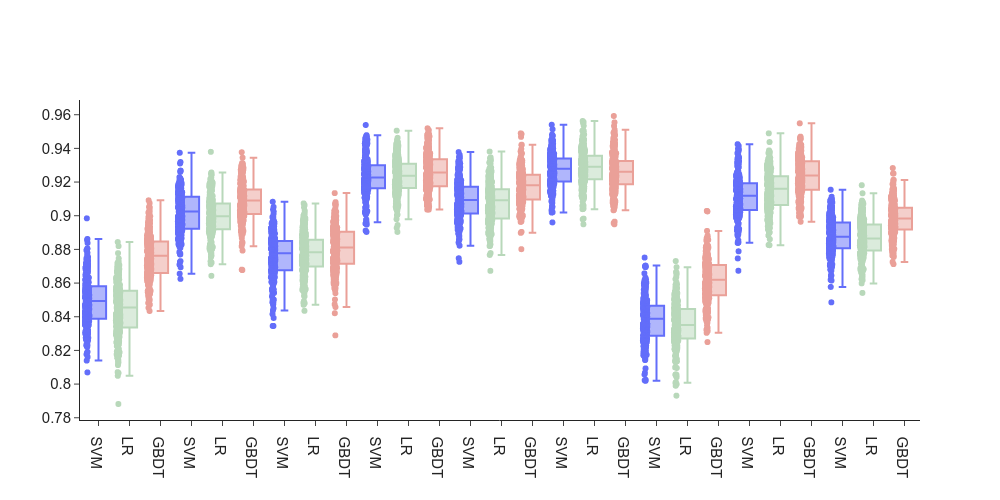

In [124]:

c_mapping_d = {
    f"Random{len_gbdt_selected} (SVM)": "#636efa",
    f"Random{len_gbdt_selected} (LR)": "#b8d8ba",
    f"Random{len_gbdt_selected} (GBDT)": "#eaa098",
    f"Random{len_svm_selected} (SVM)": "#636efa",
    f"Random{len_svm_selected} (LR)": "#b8d8ba",
    f"Random{len_svm_selected} (GBDT)": "#eaa098",
    f"Random{len_lr_selected} (SVM)": "#636efa",
    f"Random{len_lr_selected} (LR)": "#b8d8ba",
    f"Random{len_lr_selected} (GBDT)": "#eaa098",

    f"GBDT Selected{len_gbdt_selected} (SVM)": "#636efa",
    f"GBDT Selected{len_gbdt_selected} (LR)": "#b8d8ba",
    f"GBDT Selected{len_gbdt_selected} (GBDT)": "#eaa098",
    
    f"SVM Selected{len_svm_selected} (SVM)": "#636efa",
    f"SVM Selected{len_svm_selected} (LR)": "#b8d8ba",
     f"SVM Selected{len_svm_selected} (GBDT)": "#eaa098",
    
    f"LR Selected{len_lr_selected} (SVM)": "#636efa",
    f"LR Selected{len_lr_selected} (LR)": "#b8d8ba",
    f"LR Selected{len_lr_selected} (GBDT)": "#eaa098",   
    
    f"Random{num} (SVM)": "#636efa",
    f"Random{num} (LR)": "#b8d8ba",
    f"Random{num} (GBDT)": "#eaa098",
    
    f"GBDT selectedPFAM{num} (SVM)": "#636efa",
    f"GBDT selectedPFAM{num} (LR)": "#b8d8ba",
    f"GBDT selectedPFAM{num} (GBDT)": "#eaa098",
    
    f"Oxygen{num} (SVM)": "#636efa",
    f"Oxygen{num} (LR)": "#b8d8ba",
    f"Oxygen{num} (GBDT)": "#eaa098",
    
    
    
}


per_df = per_df.reindex(columns=c_mapping_d.keys())
fig = go.Figure()
for name,col in per_df.iteritems():
    c = c_mapping_d[name]
    fig.add_box(y=col,name=name,
           boxpoints='all',
                marker={'color':c},showlegend=False
               )
fig.update_layout(height=500,width=1000,template='simple_white',
                 xaxis_tickvals = list(c_mapping_d.keys()),
                 xaxis_ticktext = [_.split('(')[-1].strip(')') for _ in c_mapping_d.keys()],
                 xaxis_tickmode = "array",yaxis_dtick=0.02,
                  font_size=15,
                 )
display(Image(fig.to_image()))
#.show()
fig.write_image('/mnt/ivy/thliao/project/ML_oxygen/training_sets/processed_data/CBdist_based_filter/selectedFea_comparisons_20250410.pdf')

In [125]:
!sz2 /mnt/ivy/thliao/project/ML_oxygen/training_sets/processed_data/CBdist_based_filter/selectedFea_comparisons_20250410.pdf

ssh: connect to host 39.106.46.207 port 22: Network is unreachable
lost connection


In [157]:
fig = go.Figure()
fig.add_box(y=list(_df_NEErandom_lr_founding.loc['acc',:]), boxpoints="all", name="Randomly selected 73 features",marker=dict(color='#fc7b26'),showlegend=False)
fig.add_box(y=list(_df_NEElr_founding.loc['acc',:]), boxpoints="all", name="73 selected features",marker=dict(color='#636efa'),showlegend=False)
fig.add_box(y=list(merged_df['GBDT Selected50 (LR)']), boxpoints="all", name="gbdt50",marker=dict(color='#636efa'),showlegend=False)
#fig.add_box(y=_tmp3, boxpoints="all", name="radnomly selected 81 Pfam")
# fig.layout.width = 800
# fig.layout.height = 400
fig.update_layout(width=800,height=400,template='simple_white',font_size=18,yaxis_title='Balanced accuracy')
#fig.show()
fig.write_image('/mnt/ivy/thliao/project/ML_oxygen/prior/relevant/NEEevaluation_with_random(lr).pdf')

In [158]:
fig = go.Figure()
fig.add_box(y=list(_df_NEErandom_svm_founding.loc['acc',:]), boxpoints="all", name="Randomly selected 73 features",marker=dict(color='#fc7b26'),showlegend=False)
fig.add_box(y=list(_df_NEEsvm_founding.loc['acc',:]), boxpoints="all", name="73 selected features",marker=dict(color='#636efa'),showlegend=False)
fig.add_box(y=list(merged_df['GBDT Selected50 (SVM)']), boxpoints="all", name="gbdt50",marker=dict(color='#636efa'),showlegend=False)
#fig.add_box(y=_tmp3, boxpoints="all", name="radnomly selected 81 Pfam")
# fig.layout.width = 800
# fig.layout.height = 400
fig.update_layout(width=800,height=400,template='simple_white',font_size=18,yaxis_title='Balanced accuracy')

fig.write_image('/mnt/ivy/thliao/project/ML_oxygen/prior/relevant/NEEevaluation_with_random(svm).pdf')


In [159]:
fig = go.Figure()
fig.add_box(y=list(_df_NEErandom_gbdt_founding.loc['acc',:]), boxpoints="all", name="Randomly selected 73 features",marker=dict(color='#fc7b26'),showlegend=False)
fig.add_box(y=list(_df_NEEgbdt_founding.loc['acc',:]), boxpoints="all", name="73 selected features",marker=dict(color='#636efa'),showlegend=False)
fig.add_box(y=list(merged_df['GBDT Selected50 (GBDT)']), boxpoints="all", name="gbdt50",marker=dict(color='#636efa'),showlegend=False)
#fig.add_box(y=_tmp3, boxpoints="all", name="radnomly selected 81 Pfam")
# fig.layout.width = 800
# fig.layout.height = 400
fig.update_layout(width=800,height=400,template='simple_white',font_size=18,yaxis_title='Balanced accuracy')
#fig.show()
fig.write_image('/mnt/ivy/thliao/project/ML_oxygen/prior/relevant/NEEevaluation_with_random(gbdt).pdf')



In [51]:
related_ids = [_ for _ in NEE_df['found_id'] if str(_)!='nan' and str(_)]
print(f"{len(related_ids)}/{NEE_df.shape[0]}")

126/134


In [47]:
copy_train = pfam_bin_df.reindex(columns=related_ids).fillna(0)
larger_c = []
for _ in tqdm(range(100)):
    _df = each_eval(copy_train, y_bin, 5,model_f=LR_m_ll)
    _df = _df.T
    larger_c.append(_df)
_df_NEElr = pd.concat(larger_c, axis=1)

In [49]:
import random
NEE_random =  random.sample(list(pfam_bin_df.columns),k=len(related_ids))
copy_train = pfam_bin_df.reindex(columns=NEE_random)
larger_c = []
for _ in tqdm(range(100)):
    _df = each_eval(copy_train, y_bin, 5,model_f=LR_m_ll)
    _df = _df.T
    larger_c.append(_df)
_df_NEErandom_lr = pd.concat(larger_c, axis=1)

100%|██████████| 100/100 [01:03<00:00,  1.58it/s]


In [ ]:
fig = go.Figure()
fig.add_box(y=list(_df_NEElr.loc['acc',:]), boxpoints="all", name="126 selected features")
fig.add_box(y=list(_df_NEErandom_lr.loc['acc',:]), boxpoints="all", name="Randomly selected 126 features")
fig.add_box(y=list(merged_df['GBDT Selected50 (LR)']), boxpoints="all", name="gbdt50")
#fig.add_box(y=_tmp3, boxpoints="all", name="radnomly selected 81 Pfam")
fig.layout.width = 800
fig.layout.height = 400
fig.show()